In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/MABarbadillo/
%cd 'GWP/GWP files'
import os

In [2]:
##Install rosetta

!pip install rosetta-soil
from rosetta import rosetta, SoilData

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 16.4 MB/s eta 0:00:00


In [ ]:
#### Version_1.3
#### Comparing hydraulic conductivity values using K0 + L + Rosetta 1 parameters with values obtained using K0 + L=0.5 + Rosetta 3 parameters

#### Alpha, n, and Ks_3 values were coverted
#### Using the percent sand, silt, clay, bulk density, and volumetric water contents at -33 and -1500 kPa from 'MesoSoilv1_3.csv' file
#### Using matric potential data from 'longtermmeans.csv' file in the 'Mesotoobox - MesoSoilv1_3 Database' folder
#### Data were from 125 Mesonet sites at depths 5, 25, and 60 cm from 1998 to 2014 (long term mean).

import numpy as np   #Library that helps in numerical calculations
import pandas as pd  #Library used for handling structured data
                     #In this case, pandas read the csv file and convert the data into data frame (i.e., tables with rows and columns)

# Read the 'MesoSoilv1_3.csv' file, skipping the first row and using the second row as header
df = pd.read_csv('/content/drive/MyDrive/MABarbadillo/GWP/GWP files/MesoSoilv1_3.csv', header=0, skiprows=1)

# Extract the data from the specified columns
# In python, rows and columns start at 0
# .iloc is used for integer-location based indexing
# .tolist() converts the selected portion of the data frame into nested list format which is more flexible and covenient
# From the data frame, values needed are from depths 5, 25, and 60 which are all in odd rows
# 1::2 specifies to start reading from the second row and select the second row after that
# L is a parameter related to the tortuosity of pore space

data = df.iloc[1::2, [2, 3, 4, 5, 6, 7]].values.tolist()                                     #integers 2, 3, 4, 5, 6, and 7 specify the columns for %sand, silt, clay, bulk density (g/cm3), and volumetric water contents (cm3/cm3) at -33 and -1500 kPa, respectively
K0 = [float(item) for sublist in df.iloc[1::2, [13]].values.tolist() for item in sublist]    #extracts and converts the K0 parameter from the data frame to a float
L1 = [float(item) for sublist in df.iloc[1::2, [14]].values.tolist() for item in sublist]    #extracts and converts the L parameter from the data frame to a float
L3 = 0.5      #default value

##########################################################################################################################

# Call the function to get hydraulic parameters
mean_1, stdev_1, codes_1 = rosetta(1, SoilData.from_array(data))    #for Rosetta Ver.1
mean_3, stdev_3, codes_3 = rosetta(3, SoilData.from_array(data))    #for Rosetta Ver.3

# Extract the hydraulic parameter values from the array using Rosetta Ver.1
# Convert everything into a float before performing the operation for m1 and m3
# item[] indicates the column number
# logbase 10(alpha, n, Ks_3)

theta_r1 = [float(item[0]) for item in mean_1]
theta_s1 = [float(item[1]) for item in mean_1]
alpha1 = [10**(float(item[2])) for item in mean_1]      #[1/cm]
n1 = [10**(float(item[3])) for item in mean_1]
m1 = [1 - (1 / value) for value in n1]

# Extract the hydraulic parameter values from the array using Rosetta Ver.3
theta_r3 = [float(item[0]) for item in mean_3]
theta_s3 = [float(item[1]) for item in mean_3]
alpha3 = [10**(float(item[2])) for item in mean_3]      #[1/cm]
n3 = [10**(float(item[3])) for item in mean_3]
m3 = [1 - (1 / value) for value in n3]
Ks_3 = [10**float(item[4]) for item in mean_3]

##########################################################################################################################

# Reading the 'longtermmeans.csv' file containing the matric potentials [kPa] at 5, 25, 60 cm depth for 125 Mesonet sites
df1 = pd.read_csv('/content/drive/MyDrive/MABarbadillo/GWP/GWP files/longtermmeans.csv')

# Melt the DataFrame to convert columns MP05, MP25, and MP60 into rows with a name Matric_Potential'
# Arrangement should be similar to the arrangement in the MesoSoilv1_3.csv file (with 375 rows)
# STID = Station ID
# Sort the DataFrame by 'STID' and 'Depth' to maintain the order of the sites and depths
# Reset the index
# Remove the first three entries (string variables) [.iloc[3:]]


melted_df = df1.melt(id_vars=['STID'], value_vars=['MP05', 'MP25', 'MP60'], var_name='Depth',
                     value_name='Matric_Potential').sort_values(by=['STID', 'Depth']).reset_index(drop=True).iloc[3:]

# Convert the values in the 'Matric_Potential' column of the DataFrame melted_df into numeric data types and store as matric_potential
# 'errors = coerce' handles the errors (missing values) from the data frame and convert them to 'nan'
matric_potential = melted_df['Matric_Potential'].apply(pd.to_numeric, errors='coerce').tolist()

##########################################################################################################################

# Convert matric potential to volumetric water content (vwc) [cm3/cm3] for Rosetta Ver.1
# Element-wise based calculation [i]
vwc1 = [theta_r1[i] + ((theta_s1[i] - theta_r1[i]) *
 (1 / (1 + (-alpha1[i] * matric_potential[i])**n1[i])**m1[i])) for i in range(len(matric_potential))]

# Convert matric potential to volumetric water content (vwc) [cm3/cm3] for Rosetta Ver.3
vwc3 = [theta_r3[i] + ((theta_s3[i] - theta_r3[i]) *
 (1 / (1 + (-alpha3[i] * matric_potential[i])**n3[i])**m3[i]))for i in range(len(matric_potential))]

# Convert volumetric water content to Effective saturation (Se) [cm3/cm3] for Rosetta Ver.1
Se1 = [(vwc1[i] - theta_r1[i])/(theta_s1[i] - theta_r1[i]) for i in range(len(vwc1)) ]
# Convert volumetric water content to Effective saturation (Se) [cm3/cm3] for Rosetta Ver.3
Se3 = [(vwc3[i] - theta_r3[i])/(theta_s3[i] - theta_r3[i]) for i in range(len(vwc3)) ]

##########################################################################################################################
# Unsaturated hydraulic conductivity [cm/day] using K0 + Rosetta Ver.1 parameters (theta_r, theta_s, alpha, n, L)
# Selecting every third element from the list 'K1 or K3' that corresponds to the value at 5, 25, and 60 cm depths
K1 = [(K0[i]*Se1[i]**L1[i]) * (1 - (1-Se1[i]**(n1[i]/(n1[i]-1)))**m1[i])**2 for i in range(len(Se1))]
K1_5cm = K1[0::3]
K1_25cm = K1[1::3]
K1_60cm = K1[2::3]

# Unsaturated hydraulic conductivity [cm/day] using Ks + L = 0.5 + Rosetta Ver.3 parameters (theta_r, theta_s, alpha, n)
# Selecting every third element from the list 'K1 or K3' that corresponds to the value at 5, 25, and 60 cm depths
K3 = [Ks_3[i] * Se3[i]**L3 * (1 - (1 - Se3[i]**(1/m3[i]))**m3[i])**2 for i in range(len(Se3))]
K3_5cm = K3[0::3]
K3_25cm = K3[1::3]
K3_60cm = K3[2::3]

##########################################################################################################################

# printing of results

#print('mean1 = ', mean_1)
#print('mean3 = ', mean_3)
print('thetar1 = ', theta_r1)
print('thetar3 = ', theta_r3)
print('thetas1 = ', theta_s1)
print('thetas3 = ', theta_s3)
print('alpha1 = ', alpha1)
print('alpha3 = ', alpha3)
print('n1 = ', n1)
print('n3 = ', n3)
print('m1 = ', m1)
print('m3 = ', m3)
print('matric potential = ', matric_potential)
print('vwc_R1 = ', vwc1)
print('vwc_R3 = ', vwc3)
print('Se_R1 = ', Se1)
print('Se_R3 = ', Se3)
print('Hydraulic conductivity_Ros.V1 = ', K1)
print('Hydraulic conductivity_Ros.V3 = ', K3)

##########################################################################################################################


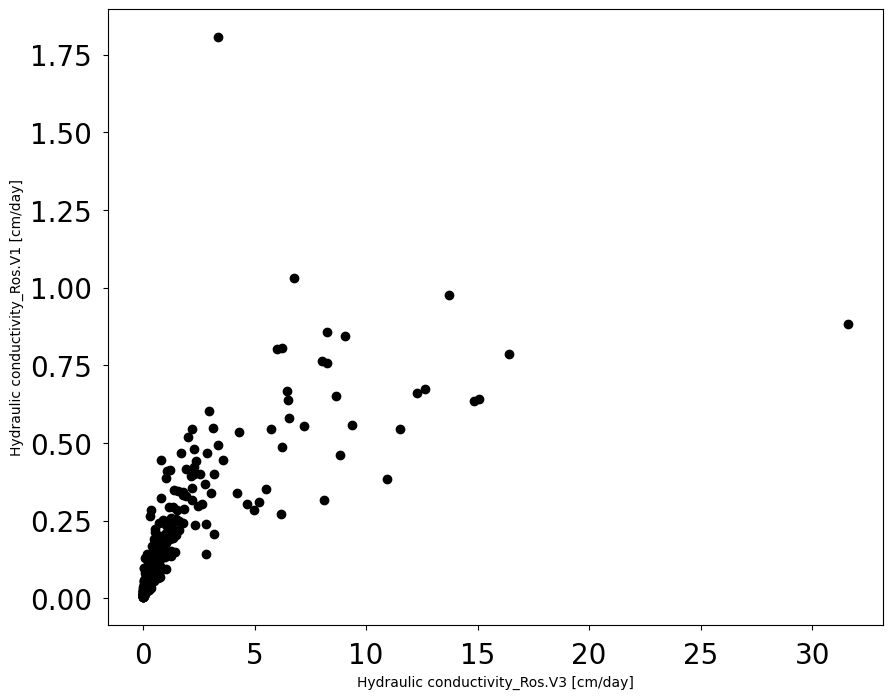

In [21]:
#Plotting of data
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.xlabel('Hydraulic conductivity_Ros.V3 [cm/day]')
plt.ylabel('Hydraulic conductivity_Ros.V1 [cm/day]')
plt.tick_params(axis='both', which='major', labelsize=20,pad=8)
plt.tick_params(axis='both', which='minor', labelsize=20,pad=8)
plt.plot(K3, K1, 'ok')

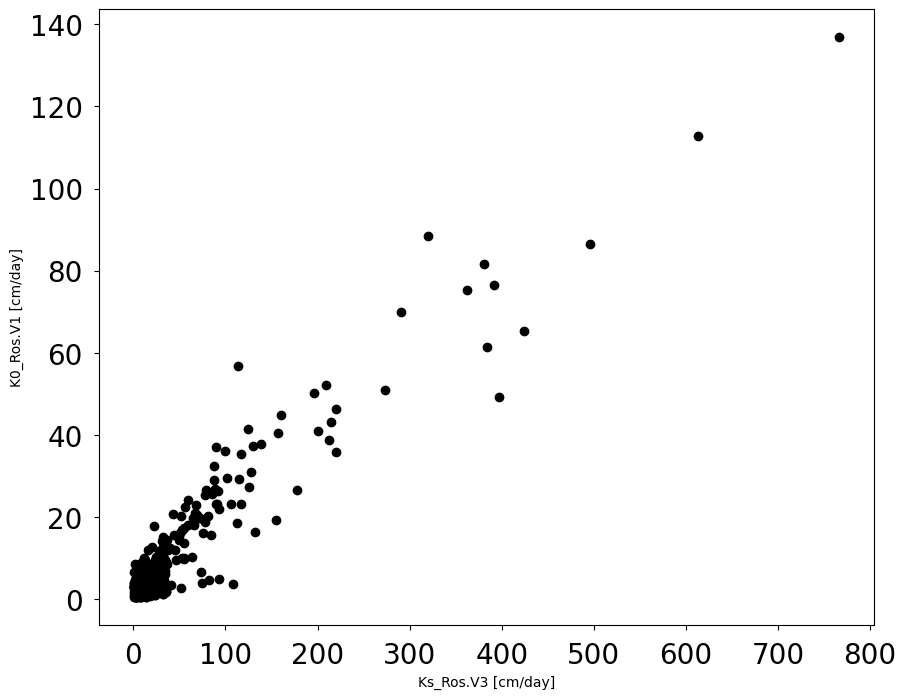

In [22]:
#Plotting of data
#Plotting K0 from Rosetta V1 versus Ks from Rosetta V3

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.xlabel('Ks_Ros.V3 [cm/day]')
plt.ylabel('K0_Ros.V1 [cm/day]')
plt.tick_params(axis='both', which='major', labelsize=20,pad=8)
plt.tick_params(axis='both', which='minor', labelsize=20,pad=8)
plt.plot(Ks_3, K0, 'ok')

In [ ]:
#### Version_1.2
#### Just comparing the saturated hydraulic conductivity obtained from V1, V2, V3

import numpy as np
import pandas as pd

# Read the 'MesoSoilv1_3.csv' file, skipping the first row and using the second row as header
df = pd.read_csv('/content/drive/MyDrive/MABarbadillo/GWP/GWP files/MesoSoilv1_3.csv', header=0, skiprows=1)
data = df.iloc[1:, [2, 3, 4, 5, 6, 7]].values.tolist()
Ks_data = [[float(val) if float(val) >= 0 else np.nan for val in row]
           for row in df.iloc[1:, [12]].values.tolist()]               #Ks value already in the MesoSoilv1_3.csv

# Call the function to get hydraulic parameters
mean_1, stdev_1, codes_1 = rosetta(1, SoilData.from_array(data))       #for Rosetta Ver.1
mean_2, stdev_2, codes_2 = rosetta(2, SoilData.from_array(data))       #for Rosetta Ver.2
mean_3, stdev_3, codes_3 = rosetta(3, SoilData.from_array(data))       #for Rosetta Ver.3

# Extract the hydraulic conductivity [cm/day] values from the array
# logbase10(Ks)
Ks_Ros1 = [10**float(item[4]) for item in mean_1]
Ks_Ros2 = [10**float(item[4]) for item in mean_2]
Ks_Ros3 = [10**float(item[4]) for item in mean_3]

# Print results
print('Ks from MesoSoilv1_3 = ', Ks_data)
print('Ks from Rosetta V1 = ', Ks_Ros1)
print('Ks from Rosetta V2 = ', Ks_Ros2)
print('Ks from Rosetta V3 = ', Ks_Ros3)


Ks from MesoSoilv1_3 =  [[193.0], [nan], [80.6], [40.9], [21.9], [14.0], [238.7], [nan], [3.0], [5.2], [0.8], [0.5], [5.9], [nan], [4.0], [1.8], [1.3], [0.7], [2.4], [nan], [8.2], [2.9], [6.7], [nan], [28.9], [18.5], [16.9], [3.7], [10.0], [3.0], [446.5], [nan], [390.3], [92.5], [27.3], [51.7], [211.3], [nan], [77.0], [15.1], [6.8], [4.5], [37.0], [nan], [8.4], [8.7], [3.2], [2.1], [20.7], [nan], [30.4], [34.0], [36.2], [38.8], [16.7], [nan], [21.5], [19.5], [29.3], [23.2], [20.0], [nan], [35.5], [nan], [nan], [nan], [172.7], [nan], [31.3], [26.5], [21.2], [11.6], [16.4], [nan], [10.6], [7.6], [2.9], [nan], [71.9], [nan], [16.0], [4.1], [2.7], [nan], [89.0], [nan], [8.8], [6.1], [3.2], [4.0], [18.6], [nan], [9.5], [1.3], [1.3], [1.2], [197.0], [nan], [16.7], [13.4], [12.5], [9.8], [27.3], [nan], [10.6], [7.2], [3.6], [3.0], [18.0], [nan], [14.3], [12.8], [17.0], [9.5], [17.4], [nan], [12.0], [11.4], [6.2], [9.2], [58.5], [nan], [38.6], [75.9], [89.5], [89.8], [18.8], [nan], [12.5], [2.

In [4]:
#### Version_1.1
#### Comparing hydraulic conductivity values using K0 + L + Rosetta 1 parameters with values obtained using K0 + L=0.5 + Rosetta 3 parameters

#### Alpha and n values were coverted
#### Using the percent sand, silt, clay, bulk density, and volumetric water contents at -33 and -1500 kPa from 'MesoSoilv1_3.csv' file
#### Using matric potential data from 'longtermmeans.csv' file in the 'Mesotoobox - MesoSoilv1_3 Database' folder
#### Data were from 125 Mesonet sites at depths 5, 25, and 60 cm from 1998 to 2014 (long term mean).

import numpy as np   #Library that helps in numerical calculations
import pandas as pd  #Library used for handling structured data
                     #In this case, pandas read the csv file and convert the data into data frame (i.e., tables with rows and columns)

# Read the 'MesoSoilv1_3.csv' file, skipping the first row and using the second row as header
df = pd.read_csv('/content/drive/MyDrive/MABarbadillo/GWP/GWP files/MesoSoilv1_3.csv', header=0, skiprows=1)

# Extract the data from the specified columns
# In python, rows and columns start at 0
# .iloc is used for integer-location based indexing
# .tolist() converts the selected portion of the data frame into nested list format which is more flexible and covenient
# From the data frame, values needed are from depths 5, 25, and 60 which are all in odd rows
# 1::2 specifies to start reading from the second row and select the second row after that
# L is a parameter related to the tortuosity of pore space

data = df.iloc[1::2, [2, 3, 4, 5, 6, 7]].values.tolist()                                     #integers 2, 3, 4, 5, 6, and 7 specify the columns for %sand, silt, clay, bulk density (g/cm3), and volumetric water contents (cm3/cm3) at -33 and -1500 kPa, respectively
K0 = [float(item) for sublist in df.iloc[1::2, [13]].values.tolist() for item in sublist]    #extracts and converts the K0 parameter from the data frame to a float
L1 = [float(item) for sublist in df.iloc[1::2, [14]].values.tolist() for item in sublist]    #extracts and converts the L parameter from the data frame to a float
L3 = 0.5      #default value

##########################################################################################################################

# Call the function to get hydraulic parameters
mean_1, stdev_1, codes_1 = rosetta(1, SoilData.from_array(data))    #for Rosetta Ver.1
mean_3, stdev_3, codes_3 = rosetta(3, SoilData.from_array(data))    #for Rosetta Ver.3

# Extract the hydraulic parameter values from the array using Rosetta Ver.1
# Convert everything into a float before performing the operation for m1 and m3
# item[] indicates the column number
# logbase 10(alpha, n)

theta_r1 = [float(item[0]) for item in mean_1]
theta_s1 = [float(item[1]) for item in mean_1]
alpha1 = [10**(float(item[2])) for item in mean_1]      #[1/cm]
n1 = [10**(float(item[3])) for item in mean_1]
m1 = [1 - (1 / value) for value in n1]

# Extract the hydraulic parameter values from the array using Rosetta Ver.3
theta_r3 = [float(item[0]) for item in mean_3]
theta_s3 = [float(item[1]) for item in mean_3]
alpha3 = [10**(float(item[2])) for item in mean_3]      #[1/cm]
n3 = [10**(float(item[3])) for item in mean_3]
m3 = [1 - (1 / value) for value in n3]

##########################################################################################################################

# Reading the 'longtermmeans.csv' file containing the matric potentials [kPa] at 5, 25, 60 cm depth for 125 Mesonet sites
df1 = pd.read_csv('/content/drive/MyDrive/MABarbadillo/GWP/GWP files/longtermmeans.csv')

# Melt the DataFrame to convert columns MP05, MP25, and MP60 into rows with a name Matric_Potential'
# Arrangement should be similar to the arrangement in the MesoSoilv1_3.csv file (with 375 rows)
# STID = Station ID
# Sort the DataFrame by 'STID' and 'Depth' to maintain the order of the sites and depths
# Reset the index
# Remove the first three entries (string variables) [.iloc[3:]]


melted_df = df1.melt(id_vars=['STID'], value_vars=['MP05', 'MP25', 'MP60'], var_name='Depth',
                     value_name='Matric_Potential').sort_values(by=['STID', 'Depth']).reset_index(drop=True).iloc[3:]

# Convert the values in the 'Matric_Potential' column of the DataFrame melted_df into numeric data types and store as matric_potential
# 'errors = coerce' handles the errors (missing values) from the data frame and convert them to 'nan'
matric_potential = melted_df['Matric_Potential'].apply(pd.to_numeric, errors='coerce').tolist()

##########################################################################################################################

# Convert matric potential to volumetric water content (vwc) [cm3/cm3] for Rosetta Ver.1
# Element-wise based calculation [i]
vwc1 = [theta_r1[i] + ((theta_s1[i] - theta_r1[i]) *
 (1 / (1 + (-alpha1[i] * matric_potential[i])**n1[i])**m1[i])) for i in range(len(matric_potential))]

# Convert matric potential to volumetric water content (vwc) [cm3/cm3] for Rosetta Ver.3
vwc3 = [theta_r3[i] + ((theta_s3[i] - theta_r3[i]) *
 (1 / (1 + (-alpha3[i] * matric_potential[i])**n3[i])**m3[i]))for i in range(len(matric_potential))]

# Convert volumetric water content to Effective saturation (Se) [cm3/cm3] for Rosetta Ver.1
Se1 = [(vwc1[i] - theta_r1[i])/(theta_s1[i] - theta_r1[i]) for i in range(len(vwc1)) ]
# Convert volumetric water content to Effective saturation (Se) [cm3/cm3] for Rosetta Ver.3
Se3 = [(vwc3[i] - theta_r3[i])/(theta_s3[i] - theta_r3[i]) for i in range(len(vwc3)) ]

##########################################################################################################################

# Calculate Hydraulic conductivity [cm/day] for Rosetta Ver.1
# Selecting every third element from the list 'K_Se1 or K_Se3' that corresponds to the value at 5, 25, and 60 cm depths
K_Se1 = [(K0[i]*Se1[i]**L1[i]) * (1 - (1-Se1[i]**(n1[i]/(n1[i]-1)))**m1[i])**2 for i in range(len(Se1))]
K_Se1_5cm = K_Se1[0::3]
K_Se1_25cm = K_Se1[1::3]
K_Se1_60cm = K_Se1[2::3]

# Calculate Hydraulic conductivity [cm/day] for Rosetta Ver.3
# L3 = 0.5
K_Se3 = [(K0[i]*Se3[i]**L3) * (1 - (1-Se3[i]**(n3[i]/(n3[i]-1)))**m3[i])**2 for i in range(len(Se3))]
K_Se3_5cm = K_Se3[0::3]
K_Se3_25cm = K_Se3[1::3]
K_Se3_60cm = K_Se3[2::3]

##########################################################################################################################

# Unsaturated Hydraulic Conductivity Calculation [cm/day]
# Selecting every third element from the list 'K1 or K3' that corresponds to the value at 5, 25, and 60 cm depths
# L3 = 0.5

K1 = [K_Se1[i] * Se1[i]**L1[i] * (1 - (1 - Se1[i]**(1/m1[i]))**m1[i])**2 for i in range(len(Se1))]
K1_5cm = K1[0::3]
K1_25cm = K1[1::3]
K1_60cm = K1[2::3]

K3 = [K_Se3[i] * Se3[i]**L3 * (1 - (1 - Se3[i]**(1/m3[i]))**m3[i])**2 for i in range(len(Se3))]
K3_5cm = K3[0::3]
K3_25cm = K3[1::3]
K3_60cm = K3[2::3]

##########################################################################################################################

#print('mean1 = ', mean_1)
#print('mean3 = ', mean_3)
print('thetar1 = ', theta_r1)
print('thetar3 = ', theta_r3)
print('thetas1 = ', theta_s1)
print('thetas3 = ', theta_s3)
print('alpha1 = ', alpha1)
print('alpha3 = ', alpha3)
print('n1 = ', n1)
print('n3 = ', n3)
print('m1 = ', m1)
print('m3 = ', m3)
print('matric potential = ', matric_potential)
print('vwc_R1 = ', vwc1)
print('vwc_R3 = ', vwc3)
print('Se_R1 = ', Se1)
print('Se_R3 = ', Se3)
print('K_SeR1 = ', K_Se1)
print('K_SeR3 = ', K_Se3)
print('K1 = ', K1)
print('K3 = ', K3)

thetar1 =  [0.019605862310376344, 0.03641116884236753, 0.05474857959565542, 0.03310334750628149, 0.04283592349552427, 0.04298037457659882, 0.060562902729090214, 0.06642032799011376, 0.06396972874845985, 0.05397384860403138, 0.0646054456235443, 0.0739662263136753, 0.02361859104080091, 0.027956415186720575, 0.04742997625045277, 0.019562980626081982, 0.018604344562925517, 0.015331693952052935, 0.02176076944348748, 0.03818589975972806, 0.05715802287873966, 0.06490707439331372, 0.06469804370888813, 0.07125712682698468, 0.037079953713248195, 0.04695594504271806, 0.05529842708709088, 0.04313297598615848, 0.051723956948818976, 0.07881083093596061, 0.04746602341320641, 0.038105477605408174, nan, 0.025267970054164347, 0.02317479243561897, 0.03120514811614807, 0.05684160224476108, 0.0681271979862858, 0.06230101611947292, 0.09150837344665873, 0.08416543493711287, 0.08097409250664558, 0.021350593813545427, 0.043979042328272835, 0.056653196952271404, 0.05759481894481851, 0.09107801416553028, 0.07467

In [ ]:
##### Version_1.0
##### Using data directly from Mesonet for years 1998 to 2014

import numpy as np   #Library that helps in numerical calculations
import pandas as pd  #Library used for handling structured data
                     #In this case, pandas read the csv file and convert the data into data frame (i.e., tables with rows and columns)

# Read the 'MesoSoilv1_3.csv' file, skipping the first row and using the second row as header
# In python, rows and columns start at 0
# .iloc is used for integer-location based indexing
# .values.tolist() converts the selected portion of the data frame into nested list format which is more flexible and covenient

df = pd.read_csv('/content/drive/MyDrive/MABarbadillo/GWP/GWP files/MesoSoilv1_3.csv', header=0, skiprows=1)
data = df.iloc[1:, [2, 3, 4, 5, 6, 7]].values.tolist()      #integers 2, 3, 4, 5, 6, and 7 specify the columns for %sand, silt, clay, bulk density (g/cm3), and volumetric water contents (cm3/cm3) at -33 and -1500 kPa, respectively
K0 = df.iloc[1:, [13]].values.tolist()                      #K0 parameter from the csv file
L1 = df.iloc[1:, [14]].values.tolist()                      #L parameter from the csv file
L3 = 0.5   #default value

# Call the function to get hydraulic parameters
mean_1, stdev_1, codes_1 = rosetta(1, SoilData.from_array(data))    #for Rosetta Ver.1
mean_3, stdev_3, codes_3 = rosetta(3, SoilData.from_array(data))    #for Rosetta Ver.3

# Extract the hydraulic parameter values from the array using Rosetta Ver.1
# Converts everything into a float before performing the operation for m1 and m3
# item[] indicates the column number
theta_r1 = [float(item[0]) for item in mean_1]
theta_s1 = [float(item[1]) for item in mean_1]
alpha1 = [float(item[2]) for item in mean_1]
n1 = [float(item[3]) for item in mean_1]
m1 = [1 - (1 / value) for value in n1]

# Extract the hydraulic parameter values from the array using Rosetta Ver.3
theta_r3 = [float(item[0]) for item in mean_3]
theta_s3 = [float(item[1]) for item in mean_3]
alpha3 = [float(item[2]) for item in mean_3]
n3 = [float(item[3]) for item in mean_3]
m3 = [1 - (1 / value) for value in n3]

# To get the matric potential from #__# Mesonet sites for years 1998-2014 at depths 5, 25, 60, and 75 cm
# Read .csv file
# Daily reference temperature
####### Not sure about the data set: whether it matches the previous data or not
df1 = pd.read_csv('/content/drive/MyDrive/MABarbadillo/GWP/GWP files/Mesonet_file.csv')
ref_Temperature = df1.iloc[1:, [5, 6, 7, 8]].values.tolist()      #Reference temperature at depths 5, 25, 60, and 75 cm
df1.iloc[1:, [5, 6, 7, 8]] = df1.iloc[1:, [5, 6, 7, 8]].applymap(lambda x: np.nan if x < 0 else x)   #Replaces values <0 to NAN
c = 0.717  #calibration constant [kPa]
a = 1.788  #calibration constant [1/C]

matric_potential = []                                             #stores the calculated matric potential values for each depth
for temperatures in ref_Temperature:
    mp_depth = [-c * np.exp(a * temp) for temp in temperatures]   #stores matric potential values for each depth
    matric_potential.append(mp_depth)                             #ensures that matric potentials are calculated based on reference temperature values at specific depth

# Convert matric potential to volumetric water content (vwc) for Rosetta Ver.1
vwc1 = theta_r1 + (theta_s1 - theta_r1) * (1 / (1 + (-alpha1 * matric_potential)**n1)**m1)    #cm3/cm3
# Convert matric potential to volumetric water content (vwc) for Rosetta Ver.3
vwc3 = theta_r3 + (theta_s3 - theta_r3) * (1 / (1 + (-alpha3 * matric_potential)**n3)**m3)    #cm3/cm3

# Convert volumetric water content to Effective saturation (Se) for Rosetta Ver.1
Se1 = (vwc1 - theta_r1)/(theta_s1 - theta_r1)    #cm3/cm3
# Convert volumetric water content to Effective saturation (Se) for Rosetta Ver.3
Se3 = (vwc3 - theta_r3)/(theta_s3 - theta_r3)    #cm3/cm3

# Calculate Hydraulic conductivity for Rosetta Ver.1
K_Se1 = (K0*Se1**L1) * (1 - (1-Se1**(n1/n1-1))**m1)**2    #cm/day
# Calculate Hydraulic conductivity for Rosetta Ver.3
# K0 values from 'MesoSoilv1_3.csv' were used
# L3 = 0.5
K_Se3 = (K0*Se3**L3) * (1 - (1-Se3**(n3/n3-1))**m3)**2    #cm/day